# Table of contents

1. [Overview](#Overview)
2. [Data Modelling](#Data_Modelling)
3. [Model Evaluation](#Model_Evaluation)
4. [Conclusion](#Conclusion)

# 1. Overview

In this notebook I will try and answer the following questions that could possible help any potential landloards and in turn promote more effienct listings for AirBnB:
* Can the nightly price be predicted?
* Which features could be most important to the price? <br>

I will be using data modeling and feature engineering to prepare the data, where I will then evaluate different types of prediction models and pick the best one that performs will with the data.

<a id='Data_Understanding'></a>
# 2. Data Understanding

### Importing Libraries

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import dataframe_image as dfi
from ast import literal_eval

%matplotlib inline

import xgboost as xgb
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import learning_curve, ShuffleSplit, RepeatedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor

### Loading Data

In [2]:
# Loading pickle file into dataframe
df_listings = pd.read_pickle('../data/interim/df_listings.pkl')

In [3]:
# Number of rows and columns in the dataframe
df_listings.shape

(77136, 74)

In [4]:
# Displaying all columns
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,90%,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",$105.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,33,63,338,2021-01-04,192,6,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,100%,75%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Long term stays allowed"", ""Lock on bedroom d...",$40.00,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,30,60,90,365,2020-12-18,21,1,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,100%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",$75.00,10,50,10.0,10.0,50.0,50.0,10.0,50.0,

<a id='Data_Modelling'></a>
# 2. Data Modeling

In [55]:
def drop_columns(df):
    
    """
    Dropping Columns that aren't needed and
    also removing columns with 70% or more of 
    missing data in the column
    
    Parameters:
    
    Dataframe
    
    Returns:
    
    Dataframe
    
    """

    regex_list = ['url','scrape','first_review','last_review','cancellation_policy','requires']
    
    for i in regex_list:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
        
    df = df.drop(columns=['id','name','description','neighborhood_overview','latitude',
                          'longitude','neighbourhood','calendar_updated','host_id', 'host_name', 
                          'host_since', 'host_location', 'host_about','host_response_time',
                          'host_response_rate', 'host_acceptance_rate', 
                          'host_neighbourhood', 'host_listings_count',
                          'host_has_profile_pic', 'host_identity_verified',
                          'minimum_minimum_nights', 'maximum_nights_avg_ntm',
                          'maximum_minimum_nights', 'minimum_maximum_nights',
                          'maximum_maximum_nights', 'minimum_nights_avg_ntm'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df.columns[df.isnull().mean()>0.70])
    df = df.drop(list(col_nulls), axis=1)
    
    return df

In [56]:
def onehot_df(df, variable, unique_items):
    
    """
    Creates one hot encoding for the specified column
    using the unique items specified
    
    Parameters:
    
    Dataframe, variable(string), unique_items(list)
    
    Returns:
    
    Dataframe
    
    """
    
    item_lists = df[variable]
    
    # Loop through all the labels
    for i, label in enumerate(unique_items):
        
        # Creating new column for each label
        df[variable+'_'+label] = item_lists.apply(lambda x: 1 if label in x else 0)
    
    # Removing old column
    del df[variable]
            
    # Return the results as a dataframe
    return df

In [57]:
def to_1D(series):
    
    """
    Creates a 1D array
    
    Paramters:
    
    Series
    
    Returns:
    
    Array
    
    """
    
    return pd.Series([x for _list in series for x in _list])

In [58]:
# Dropping unwanted columns
df_listings = drop_columns(df_listings)

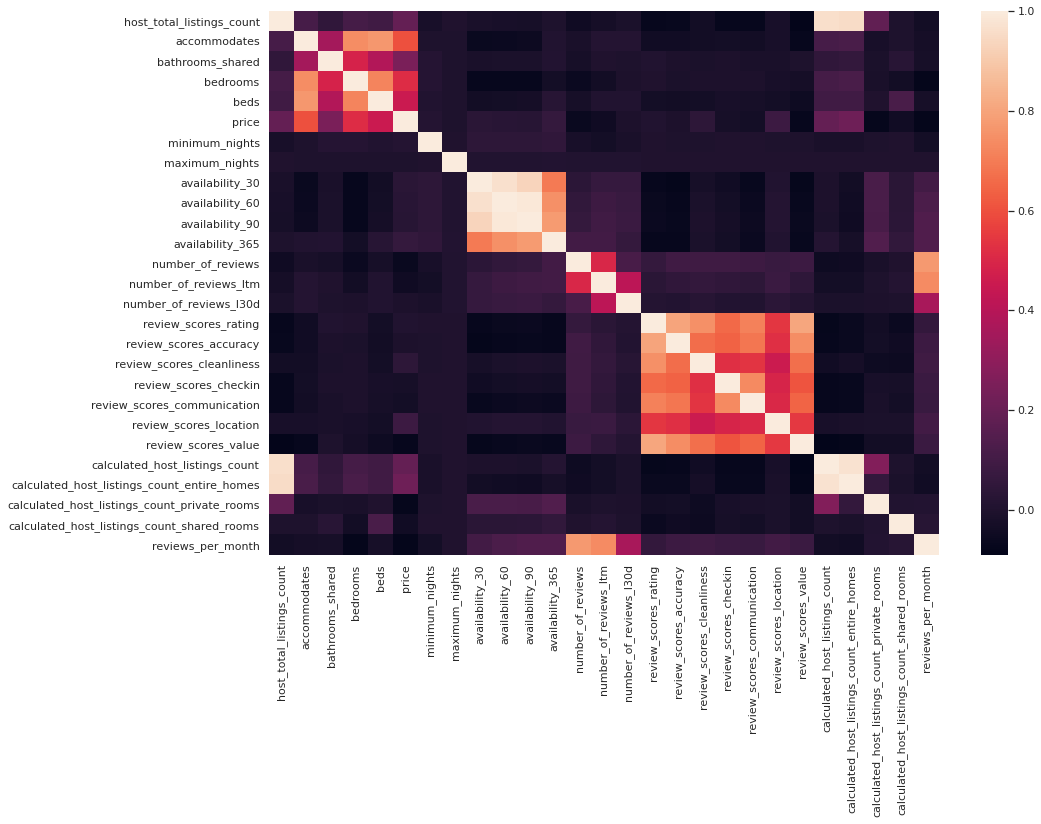

In [59]:
# Finding the columns that have an correlation with the price column
# calculate the correlation matrix
corr = df_listings.corr()

plt.figure(figsize = (15,10))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [60]:
# Checking labels for the object type data
for col in df_listings.select_dtypes(include=['object']).columns:
    print(col, ': ', len(df_listings[col].unique()), 'labels')

host_is_superhost :  3 labels
host_verifications :  535 labels
neighbourhood_cleansed :  33 labels
property_type :  89 labels
room_type :  4 labels
amenities :  67099 labels
has_availability :  2 labels
instant_bookable :  2 labels


In [61]:
# Checking Property Type labels
df_property_type = df_listings["property_type"].value_counts()

In [62]:
# Amenities expansion to label encoding
df_listings["amenities"] = df_listings["amenities"].apply(eval)

In [63]:
# host_verifications expansion to label encoding
df_listings["host_verifications"] = df_listings["host_verifications"].apply(eval)

In [64]:
# Creating new features for number of amenities and verification types
df_listings['amenities_len'] = df_listings['amenities'].str.len()
df_listings['verifications_len'] = df_listings['host_verifications'].str.len()

del df_listings['host_verifications']

In [65]:
# Creating new property type column
df_listings["property_type"] = df_listings["property_type"].str.split().str[-1]

In [66]:
# Creating the top 10 amenities
df_amenities_top_10 = pd.DataFrame(to_1D(df_listings["amenities"]).value_counts().head(50)).index

df_amenities_top_10

Index(['Wifi', 'Heating', 'Essentials', 'Kitchen', 'Smoke alarm', 'Washer',
       'Hangers', 'Iron', 'TV', 'Hair dryer', 'Shampoo', 'Dedicated workspace',
       'Carbon monoxide alarm', 'Hot water', 'Dryer', 'Refrigerator',
       'Dishes and silverware', 'Cooking basics', 'Oven', 'Bed linens',
       'Microwave', 'Stove', 'Fire extinguisher', 'First aid kit',
       'Private entrance', 'Dishwasher', 'Long term stays allowed',
       'Coffee maker', 'Free parking on premises', 'Elevator',
       'Lock on bedroom door', 'Extra pillows and blankets', 'Host greets you',
       'Cable TV', 'Luggage dropoff allowed', 'Patio or balcony',
       'Garden or backyard', 'Breakfast', 'Paid parking off premises',
       'Lockbox', 'Free street parking', 'Bathtub', 'Shower gel',
       'Indoor fireplace', 'Single level home', 'Air conditioning',
       'High chair', 'Paid parking on premises', 'Private living room',
       'Children’s books and toys'],
      dtype='object')

In [67]:
# Creating the top 20 property types
df_new_property_top_20 = pd.DataFrame(df_listings["property_type"].value_counts().head(20)).index

df_new_property_top_20

Index(['apartment', 'house', 'townhouse', 'condominium', 'loft', 'breakfast',
       'hotel', 'suite', 'guesthouse', 'hostel', 'bungalow', 'aparthotel',
       'room', 'cottage', 'Boat', 'home/apt', 'villa', 'place', 'cabin',
       'Houseboat'],
      dtype='object')

In [68]:
# Applying the one hot encoding for the top 10 amenities
df_listings = onehot_df(df_listings,"amenities", df_amenities_top_10)

In [69]:
# Applying the one hot encoding for the top 20 property types
df_listings = onehot_df(df_listings,"property_type", list(df_new_property_top_20))

In [70]:
# Confirming the shape of the df_listings
df_listings.shape

(71823, 104)

#### Train / Test split

In [71]:
# Removing any rows with NaN values
df_listings = df_listings.dropna()

In [72]:
# Removing rows that do not have a price
# df = df_listings.dropna(subset=["price"])
df_listings = df_listings[df_listings['price'] != 0]

In [73]:
# Extract features and labels
X = df_listings.drop("price", axis=1) # drop labels for training set
y = df_listings["price"].copy()

# List of features for later use
X_columns = list(X.columns)

In [74]:
# Applying the train / test split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [75]:
# Confirming the rows and columns are the 
# same for train and test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32651, 103)
(13994, 103)
(32651,)
(13994,)


#### Creating the data pipeline

In [76]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    """
    A class to select numerical or categorical columns
    
    """
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return X[self.attribute_names]

In [77]:
# Selecting required dataframe for transformation
X_train_num = X_train.select_dtypes(include=['float', 'int'])
X_train_cat = X_train.select_dtypes(include=['object'])

In [78]:
# Columns of dataframes selected
num_attribs = list(X_train_num.columns)
cat_attribs = list(X_train_cat.columns)

In [79]:
# Category pipeline, using one hot encoding
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(handle_unknown = 'ignore')),
    ])

In [80]:
# Number pipeline, adding any missing data with median and 
# applying scaler to the data
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ])

In [81]:
# Joining category and numerical pipelines
full_pipeline = Pipeline([
       ('features', FeatureUnion([
                    ("num_pipeline", num_pipeline),
                    ("cat_pipeline", cat_pipeline)
                ])
        )])

In [82]:
# Transforming train and test data
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [83]:
# Confiming the layout after transformation
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(32651, 141)
(13994, 141)


<a id='Model_Evaluation'></a>
# 3. Model Evaluation

In [84]:
def base_models(model, X_train, X_test, y_train, y_test):
    
    """
    Function for fitting and predicting with the quired model
    
    Parameters:
    
    model, X_train, X_test, y_train, y_test
    
    Returns:
    
    RMSE
    
    """
    
    start_time = time.time()
   
    model.fit(X_train, y_train)
    
    predict_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predict_train)
    rmse_train = np.sqrt(mse_train)
    
    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("--- " + str(time_taken) + " minutes ---")
    
    print("RMSE: Train data " + str(round(rmse_train,2)))

In [85]:
def display_scores(model, X_train, y_train):
    
    """
    Function for applying the cross validation score
    
    Parameters:
    
    model, X_train, y_train
    
    Returns:
    
    RMSE - Scores, Average and Standard Deviation
    
    """
    
    cv = 5
    
    start_time = time.time()
    
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    
    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("--- " + str(time_taken) + " minutes ---")
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("Standard deviation of RMSE scores:", rmse_scores.std())

In [86]:
# "https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html"

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

#### Base Evaluation - Fittng the training data with various models

In [87]:
# Linear Regression - Base Model
lm = LinearRegression(n_jobs=-1)
base_models(lm, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.033 minutes ---
RMSE: Train data 31.93


In [88]:
# Ridge Regression - Base Model
ridge = Ridge()
base_models(ridge, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.009 minutes ---
RMSE: Train data 31.93


In [89]:
# Decision Tree Regression - Base Model
tree_reg = DecisionTreeRegressor(random_state=42)
base_models(tree_reg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.426 minutes ---
RMSE: Train data 0.0


In [90]:
# Random Forest Regression - Base Model
forest_reg = RandomForestRegressor(n_jobs=-1,random_state=42)
base_models(forest_reg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 5.795 minutes ---
RMSE: Train data 11.48


In [91]:
# Gradient Boosting Regressor - Base Model
grad_booreg = GradientBoostingRegressor(random_state=42)
base_models(grad_booreg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.35 minutes ---
RMSE: Train data 30.65


In [92]:
# XGBRegressor - Base Model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
base_models(xg_reg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.09 minutes ---
RMSE: Train data 23.38


#### Model with cross-validation

In [93]:
# Ridge Regression - CV Model
display_scores(ridge, X_train_prepared, y_train)

--- 0.036 minutes ---
RMSE Scores: [31.60714049 32.05243566 32.6207457  32.35950677 31.89814007]
RMSE Mean: 32.10759373767399
Standard deviation of RMSE scores: 0.35331340774239056


In [94]:
# Random Forest Regression - CV Model
display_scores(forest_reg, X_train_prepared, y_train)

--- 20.144 minutes ---
RMSE Scores: [29.91712304 31.09994038 31.22171174 31.23176308 30.93850755]
RMSE Mean: 30.88180915752942
Standard deviation of RMSE scores: 0.49384547297521814


In [95]:
# Gradient Boosting Regressor - CV Model
display_scores(xg_reg, X_train_prepared, y_train)

--- 0.311 minutes ---
RMSE Scores: [29.05378736 30.25956127 30.30053677 30.26476574 29.88927778]
RMSE Mean: 29.95358578629551
Standard deviation of RMSE scores: 0.4742576666806992


#### Visualising Train and Test scores by the number of training points

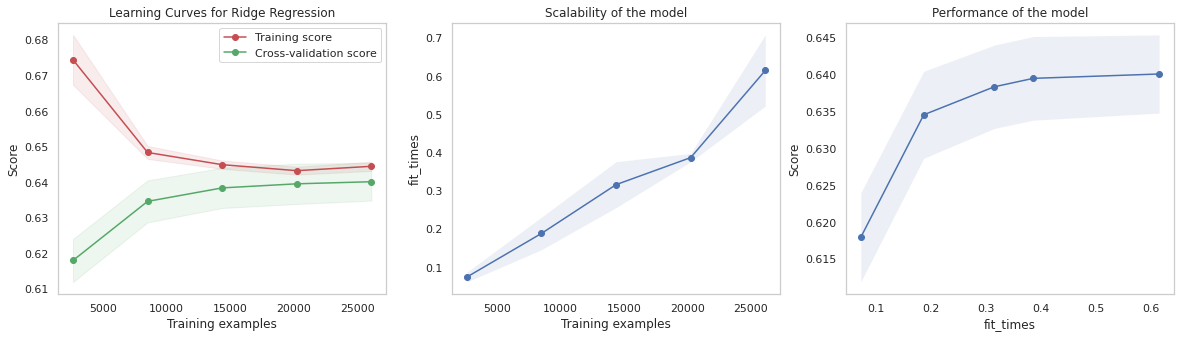

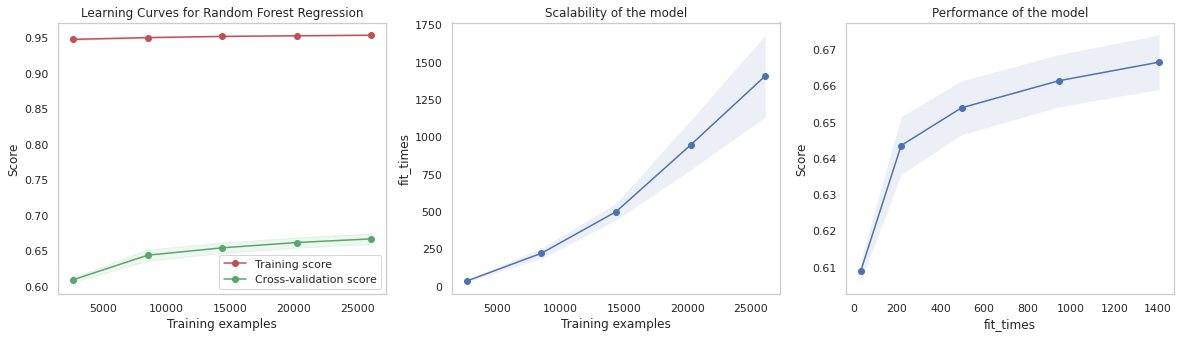

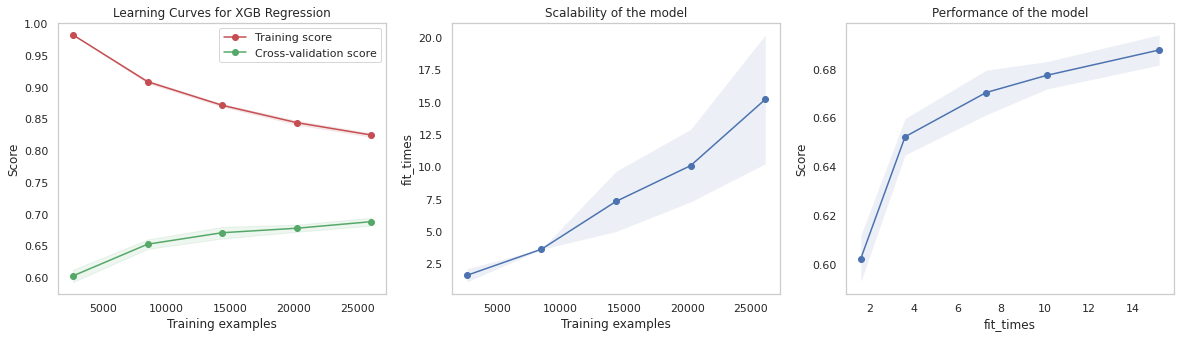

In [96]:
# Ridge Regression:
title = r"Learning Curves for Ridge Regression"
estimator = Ridge()
plot_learning_curve(estimator, title, X_train_prepared, y_train, cv=5, n_jobs=5)

# Random Forest Regression:
title = r"Learning Curves for Random Forest Regression"
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=5)

# Xtreme Gradient Boosting Regressor:
title = r"Learning Curves for XGB Regression"
estimator= xgb.XGBRegressor(objective ='reg:squarederror')
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=5)

plt.show()

#### Fine tunning the model

In [97]:
# Applying GridSearchCV on the extreme gradient boost algorithm
xgb1 = xgb.XGBRegressor()

parameters = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [7, 8, 9],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_prepared,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=False,
                                    verbosity=None),
             n

In [98]:
# The best score and paramters
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.7055175046219766
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [99]:
# Predicting the prices with the test data
pred_x = xgb_grid.predict(X_test_prepared)

# Calculating the RMSE
mse = mean_squared_error(y_test,pred_x)
rmse = np.sqrt(mse)
rmse

30.283032660473236

#### Feature Importance

In [100]:
# Final model and parameters
xgb2 = xgb.XGBRegressor(colsample_bytree = 0.7, 
                        learning_rate = 0.05, 
                        max_depth = 7, 
                        min_child_weight = 4, 
                        n_estimators = 500, 
                        nthread = 4, 
                        objective = 'reg:squarederror', 
                        silent = 1, 
                        subsample = 0.7)

xgb2.fit(X_train_prepared,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=None)

In [101]:
# feature importance scores
print(xgb2.feature_importances_)

[0.00438707 0.01566386 0.03291502 0.01975249 0.00249802 0.00244996
 0.00334578 0.00386191 0.00443955 0.00376734 0.00285675 0.00211691
 0.00316369 0.00342854 0.00248029 0.00215224 0.00319258 0.00238664
 0.00238596 0.00739706 0.00295314 0.00375403 0.00825195 0.00410782
 0.00607979 0.00257778 0.00211529 0.00254647 0.00230359 0.00256336
 0.0046275  0.00246933 0.00224462 0.0022319  0.00241023 0.00282209
 0.00718144 0.00347103 0.00288192 0.00222516 0.00215258 0.00250643
 0.00559546 0.0024106  0.00174845 0.00205776 0.00230675 0.00220019
 0.00217226 0.00186891 0.00220947 0.00212713 0.00203025 0.00734198
 0.00194738 0.00392749 0.0031782  0.0034086  0.00211037 0.00223742
 0.00208251 0.00227583 0.00214072 0.00208235 0.0019303  0.0020702
 0.00273925 0.00272507 0.00518767 0.00208064 0.00218738 0.00402224
 0.00184072 0.00612492 0.00369841 0.00269946 0.00158815 0.00270332
 0.00183873 0.003194   0.00233683 0.00234252 0.00322685 0.00316226
 0.00959588 0.00253035 0.00080291 0.00395439 0.0004741  0.00101

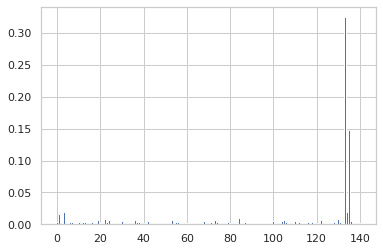

In [102]:
# ploting the features importance scores
plt.bar(range(len(xgb2.feature_importances_)), xgb2.feature_importances_)
plt.show()

In [119]:
# Creating the columns names of the data transformation
cat_one_hot_attribs = cat_pipeline.named_steps.cat_encoder.get_feature_names()
attributes = num_attribs + list(cat_one_hot_attribs)

# Displaying the top ten feature importance scores
sorted(zip(xgb2.feature_importances_,attributes),reverse=True)[:10]

[(0.3246833, 'x2_Entire home/apt'),
 (0.1480986, 'x2_Private room'),
 (0.032915022, 'bathrooms_shared'),
 (0.019752493, 'bedrooms'),
 (0.018543068, 'x2_Hotel room'),
 (0.017772589, 'x1_Westminster'),
 (0.015722068, 'x1_Kensington and Chelsea'),
 (0.015663859, 'accommodates'),
 (0.00959588, 'property_type_hotel'),
 (0.00839201, 'x1_Croydon')]

<a id='Conclusion'></a>
# 4. Conclusion

With my final investigation I wanted to see if I could predict the price of a listing for a night, what would be the minimal difference between the actual price and the prediction? What would be the features of importance that could have an impact and could this help the potential landlords?

I found that the prediction model that performed the best, was the "Xtreme Gradient Boost" algorithm. I could predict prices with plus or minus £30 difference from the actual price. When I investigated the features of the results, I found that the property type and area certainly had an effect on the price, and this would confirm that my previous investigation of the average price for each borough was correct.